In [12]:
import numpy as np
import rdkit
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, RDConfig, Geometry, RDLogger
from rdkit.Chem import AllChem, ChemicalFeatures, rdDistGeom, rdMolTransforms, rdShapeAlign, FeatMaps, Draw
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
from rdkit.Chem.Draw import IPythonConsole, MolDrawing
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
import os
import itertools
import copy
DrawingOptions.includeAtomNumbers=True

what to do:
try 1hpv ligand as test case
load in reference ph4 from MOE format
create either one or two ph4 objects (one for essential features, one for non-essential)
- the ebits field in MOE output has this information, 0 for non-essential and 1 for essential
load Mol object for ligand to be screened
check if all essential features are present in screening ligand
embed ligand based on essential features
- consider doing this in a two-step process, with single-atom features (donors, acceptors, etc.) first and multi-atom features afterwards
- ignore fused rings for now; those will be the most difficult to handle
refine alignment with non-essential features
do feature tversky/tanimoto scoring
output aligned conformer, feature score
make outputs in MOE format

In [2]:
def ph4_from_MOE(moe):
    '''
    Extract rdkit-compatible pharmacophores from MOE-format input
    Args:
    moe: MOE description of pharmacophore
    Returns:
    essential_ph4: rdkit pharmacophore containing only features marked as "essential" in MOE
    full_ph4: rdkit pharmacophore containing all features in moe
    essential_radii: list of feature radii for essential features, as defined in MOE
    all_radii: list of feature radii for all features, as defined in MOE
    '''
    ph4Info = {}
    header = []
    content = []
    for line in moe.split("\n"):
        if line[0] == "#":
            if len(header) > 0:
                ph4Info[header[0]] = (header,content)
                header = []
                content = []
            header = line.strip().split()
        else:
            content.extend(line.strip().split())
    essential_feats = []
    non_essential_feats = []
    essential_radii = []
    non_essential_radii = []
    type_conversions = {"Acc":"Acceptor","Don":"Donor","Aro":"Aromatic","Hyd":"Hydrophobe",
                       "Ani":"NegIonizable","Cat":"PosIonizable"}
    header, content = ph4Info['#feature']
    num_feats = int(header[1])
    len_feature = int((len(header)/2)-1)
    for i in range(num_feats):
        essential = content[(len_feature*i)+6]
        feat_type = content[(len_feature*i)]
        (x,y,z) = (float(content[(len_feature*i)+2]),float(content[(len_feature*i)+3]),
                   float(content[(len_feature*i)+4]))
        r = float(content[(len_feature*i)+5])
        if essential == '1':
            essential_feats.append(ChemicalFeatures.FreeChemicalFeature(type_conversions[feat_type],
                                                                       Geometry.Point3D(x,y,z)))
            essential_radii.append(r)
        else:
            non_essential_feats.append(ChemicalFeatures.FreeChemicalFeature(type_conversions[feat_type],
                                                                       Geometry.Point3D(x,y,z)))
            non_essential_radii.append(r)
    essential_ph4 = Pharmacophore.Pharmacophore(essential_feats)
    all_feats = essential_feats+non_essential_feats
    full_ph4 = Pharmacophore.Pharmacophore(all_feats)
    all_radii = essential_radii + non_essential_radii
    
    return essential_ph4, full_ph4, essential_radii, all_radii

In [38]:
moe = '''#moe:ph4que 2024.06
#pharmacophore 7 tag t value *
scheme t Unified matchsize i 0 use_Hs i 1 abspos i 0 title t $ useRval i
0 comment s $
#feature 6 expr tt color ix x r y r z r r r ebits ix gbits ix m ix
Aro ff8000 8.85883333333334 16.6941666666667 14.2638333333333 1 1 400 a64cff 
Aro ff8000 13.1003333333333 13.6336666666666 7.54116666666666 1 0 400 a64cff 
Acc df2f2 11.053 16.082 1.515 1 1 400 a64cff 
Don f20df2 8.84 17.322 16.898 1 1 400 a64cff 
Acc df2f2 9.081 15.313 6.287 1 0 400 a64cff
Acc df2f2 10.051 15.511 10.847 1 0 400 a64cff
#endpharmacophore'''
eph4, ph4, e_radii, radii = ph4_from_MOE(moe)
eph4.getFeatures()

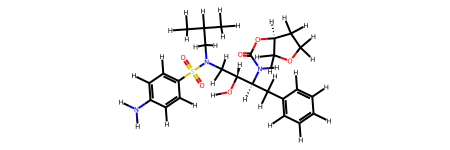

In [48]:
smi = "CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)O[C@H]2CCOC2)[S](=O)(=O)c3ccc(N)cc3"
ligand = molecule_from_smiles_3D(smi,embed=False)
ligand

In [40]:
eph4 = fuzzify_ph4(eph4)
ph4 = fuzzify_ph4(ph4)

In [49]:
align_fail, best_dev, best_mol = align_mol_to_ph4(ligand,ph4,
                                                  embed_count=100,optimize_energies=False,verbose=True)

Molecule features can match pharmacophore; proceeding to embed


[19:04:23] DEBUG: Removed embedding due to chiral constraints.

[19:04:23] DEBUG: Removed embedding due to chiral constraints.

[19:04:23] DEBUG: Removed embedding due to chiral constraints.

[19:04:23] DEBUG: Removed embedding due to chiral constraints.

[19:04:23] DEBUG: Removed embedding due to chiral constraints.

[19:04:24] DEBUG: Removed embedding due to chiral constraints.

[19:04:24] DEBUG: Removed embedding due to chiral constraints.

[19:04:24] DEBUG: Removed embedding due to chiral constraints.

[19:04:24] DEBUG: Removed embedding due to chiral constraints.

[19:04:24] DEBUG: Removed embedding due to chiral constraints.

[19:04:24] INFO: Embed failed

[19:04:25] DEBUG: Removed embedding due to chiral constraints.

[19:04:25] DEBUG: Removed embedding due to chiral constraints.

[19:04:25] DEBUG: Removed embedding due to chiral constraints.

[19:04:25] DEBUG: Removed embedding due to chiral constraints.

[19:04:25] DEBUG: Removed embedding due to chiral constraints.

[19:04:25

7 embeddings created successfully; proceeding to align
Alignment complete
Minimum SSD: 9.813920883370713
Done


[19:04:36] DEBUG: Removed embedding due to chiral constraints.



In [67]:
feature_path = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
feature_factory = ChemicalFeatures.BuildFeatureFactory(feature_path)
match_pass, matches = EmbedLib.MatchPharmacophoreToMol(ligand,feature_factory,eph4)
matches

[(<rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x1555194362d0>,
  <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519436260>),
 (<rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519436500>,
  <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519436730>),
 (<rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x1555194367a0>,
  <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519436880>)]

In [74]:
for match in itertools.product(matches[0],matches[1],matches[2]):
    atom_match = [f.GetAtomIds() for f in match]
    print(atom_match)

[(10, 11, 12, 13, 14, 15), (7,), (7,)]
[(10, 11, 12, 13, 14, 15), (7,), (16,)]
[(10, 11, 12, 13, 14, 15), (7,), (32,)]
[(10, 11, 12, 13, 14, 15), (18,), (7,)]
[(10, 11, 12, 13, 14, 15), (18,), (16,)]
[(10, 11, 12, 13, 14, 15), (18,), (32,)]
[(10, 11, 12, 13, 14, 15), (19,), (7,)]
[(10, 11, 12, 13, 14, 15), (19,), (16,)]
[(10, 11, 12, 13, 14, 15), (19,), (32,)]
[(10, 11, 12, 13, 14, 15), (23,), (7,)]
[(10, 11, 12, 13, 14, 15), (23,), (16,)]
[(10, 11, 12, 13, 14, 15), (23,), (32,)]
[(10, 11, 12, 13, 14, 15), (26,), (7,)]
[(10, 11, 12, 13, 14, 15), (26,), (16,)]
[(10, 11, 12, 13, 14, 15), (26,), (32,)]
[(10, 11, 12, 13, 14, 15), (27,), (7,)]
[(10, 11, 12, 13, 14, 15), (27,), (16,)]
[(10, 11, 12, 13, 14, 15), (27,), (32,)]
[(28, 29, 30, 31, 33, 34), (7,), (7,)]
[(28, 29, 30, 31, 33, 34), (7,), (16,)]
[(28, 29, 30, 31, 33, 34), (7,), (32,)]
[(28, 29, 30, 31, 33, 34), (18,), (7,)]
[(28, 29, 30, 31, 33, 34), (18,), (16,)]
[(28, 29, 30, 31, 33, 34), (18,), (32,)]
[(28, 29, 30, 31, 33, 34), (19

In [13]:
def align_mol_to_ph4_twostage(mol, essential_ph4, full_ph4, feature_factory=None,
                             embed_count=100, verbose=False):
    # get default feature factory
    if feature_factory == None:
        feature_path = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
        feature_factory = ChemicalFeatures.BuildFeatureFactory(feature_path)
        
    # check to ensure all essential ph4 features are present in query
    match_pass, matches = EmbedLib.MatchPharmacophoreToMol(mol, feature_factory, essential_ph4)
    if not match_pass:
        if verbose:
            print("Molecule does not have all essential features")
        return "coarse_match", None
    elif verbose:
        print("Molecule has all essential features; refining match")
    
    # refine essential feature match using bounds matrix
#     bounds = rdDistGeom.GetMoleculeBoundsMatrix(mol)
#     # first, refine 
#     essential_feats = essential_ph4.getFeatures()
#     for i in range(len(essential_feats)):
        
#     bm_fail, bounds_matrix_matched, matched, match_details = EmbedLib.MatchPharmacophore(matches,bounds,
#                                                                                          single_atom_eph4,
#                                                                                          use_downsampling=True)
#     if bm_fail:
#         if verbose:
#             print("Bounds-matrix-based matching failed")
#         return "bounds", None, None
#     elif verbose:
#         print("Bounds-matrix matching success; proceeding to embed")

    # experiment: try embedding every combination of matches to ph4
    all_embeds = []
    RDLogger.DisableLog('rdApp.*')
    for match in itertools.product(*matches):
        atom_match = [f.GetAtomIds() for f in match]
        embeddings = []
        test_mol = copy.deepcopy(mol)
        try:
            bm, embeddings, num_failed = EmbedLib.EmbedPharmacophore(test_mol,atom_match,essential_ph4,
                                                                     smoothFirst=False,count=100)
        except:
            pass
        if verbose and len(embeddings)>0:
            print(f"{len(embeddings)} embeddings successfully created")
        all_embeds = all_embeds+embeddings
    RDLogger.EnableLog('rdApp.*')
    return 0, all_embeds

In [14]:
failed, embeds = align_mol_to_ph4_twostage(ligand,eph4,ph4,verbose=True)

Molecule has all essential features; refining match
8 embeddings successfully created
2 embeddings successfully created
11 embeddings successfully created
14 embeddings successfully created
1 embeddings successfully created


In [23]:
moePh45Point = """#moe:ph4que 2014.09
#pharmacophore 7 tag t value *
scheme t Unified matchsize i 0 use_Hs i 1 abspos i 0 title t $ useRval i
0 comment s $
#feature 5 expr tt color ix x r y r z r r r ebits ix gbits ix m ix
Acc df2f2 3.877 7.014 1.448 1 1 400 a64cff 
Acc df2f2 7.22 11.077 5.625 1 1 400 a64cff 
Don f20df2 4.778 8.432 7.805 1 1 400 a64cff 
Aro ff8000 1.56433333333334 7.06399999999999 3.135 1 1 400 a64cff 
Aro ff8000 6.68983333333333 11.6213333333333 4.498 1 1 400 a64cff
#endpharmacophore"""
eph4, ph4, e_radii, radii = ph4_from_MOE(moePh45Point)
test_mol = molecule_from_smiles_3D('c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1',embed=False)
feature_path = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
feature_factory = ChemicalFeatures.BuildFeatureFactory(feature_path)
match_pass, matches = EmbedLib.MatchPharmacophoreToMol(test_mol,feature_factory,eph4)
matches

[(<rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519ad0740>,
  <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519ad06d0>),
 (<rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519ad0740>,
  <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519ad06d0>),
 (<rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519ad05f0>,
  <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519ad0820>),
 (<rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519ad0890>,
  <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519ad09e0>),
 (<rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519ad0890>,
  <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x155519ad09e0>)]

In [35]:
match = [matches[3][0],matches[1][1],matches[2][1],matches[0][0],matches[4][1]]
atom_match = [f.GetAtomIds() for f in match]
atom_match

[(4, 5, 6, 7, 8), (12,), (6,), (5,), (0, 1, 2, 3, 19, 20)]

In [37]:
assigned_atoms = []
for i in range(len(atom_match)):
    atom_set = list(atom_match[i])
    if len(atom_set) == 1:
        assigned_atoms.append(atom_set[0])
for i in range(len(atom_match)):
    atom_set = list(atom_match[i])
    if len(atom_set)>1:
        new_atom_set = [a for a in atom_set if a not in assigned_atoms]
        atom_match[i] = tuple(new_atom_set)
    assigned_atoms = assigned_atoms + [a for a in atom_set if a not in assigned_atoms]
atom_match

[(4, 7, 8), (12,), (6,), (5,), (0, 1, 2, 3, 19, 20)]

In [42]:
def mols_from_sdf(supp_file):
    '''
    Helper function to extract molecules from sdf file, with explicit hydrogens
    Args:
    supp_file: .sdf file containing molecules
    Returns:
    mols: list of molecules from supp_file, with explicit hydrogens added
    '''
    with Chem.SDMolSupplier(supp_file,removeHs=False) as supplier:
        mols = [Chem.AddHs(x) for x in supplier if x is not None] 
        # add explicit hydrogens for ease of later conformer generation
    return mols

def molecule_from_smiles_3D(smiles,embed=False):
    '''
    Helper function to generate molecules with optional 3D embedding from SMILES string
    Args:
    smiles: SMILES string to generate molecule from
    embed: whether to generate a 3D embedding of the molecule
    Returns:
    molecule: RDKit molecule object corresponding to smiles, with explicit hydrogens.
        if embed==True, also contains a 3D embedding
    '''
    molecule = Chem.MolFromSmiles(smiles)
    molecule = Chem.AddHs(molecule) # downstream RDKit functions like having explicit hydrogens, so this is hardcoded
    if embed: # generate 3D embedding if desired
        AllChem.EmbedMolecule(molecule)
        AllChem.MMFFOptimizeMolecule(molecule)
    return molecule

def fuzzify_ph4(ph4, rad_dict = {},default_radius=1.08265):
    '''
    Edits bounds matrix of a pharmacophore object to allow for positional uncertainty
    Args:
    ph4: pharmacophore object to operate on
    rad_dict: dictionary with radii [Angstroms] for each feature type.
        feature types present in ph4 but not rad_dict will be assigned default radius
    default_radius: radius to assign to feature types not explicitly listed in rad_dict
        default value of 1.08265 taken from https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-3-13
    Returns:
    ph4_fuzzy: pharmacophore object with edited bounds matrix
    '''
    
    # initialize radii for any feature types not provided
    features = ph4.getFeatures()
    unique_types = pd.unique(pd.Series([feature.GetFamily() for feature in features]))
    for family in unique_types:
        if family not in rad_dict:
            rad_dict[family] = default_radius
#     print(rad_dict)
    
    # get feature type for each feature and create mapping
    feature_types = {}
    for i in range(len(features)):
        feat_type = features[i].GetFamily()
        feature_types[i] = feat_type
#     print(feature_types)

    # update bounds matrix
    ph4_fuzzy = Pharmacophore.Pharmacophore(features)
    for i in range(len(features)):
        i_type = feature_types[i]
        for j in range(i+1, len(features)):
            j_type = feature_types[j]
            max_uncertainty = rad_dict[i_type]+rad_dict[j_type]
            ph4_fuzzy.setLowerBound(i,j,max(ph4_fuzzy.getLowerBound(i,j)-max_uncertainty,0))
            ph4_fuzzy.setUpperBound(i,j,ph4_fuzzy.getUpperBound(i,j)+max_uncertainty)

    return ph4_fuzzy
    
def ph4_from_molecule(molecule,feature_factory=None,minimal=False,fuzzy=True,rad_dict={},default_radius=1.08265):
    '''
    Generate pharmacophore model from a RDKit molecule
    Args:
    molecule: query molecule to generate pharmacophore for
    feature_factory: rdkit feature factory containing ph4 feature definitions.
        if None, will initialize default feature factory that was installed with rdkit
    minimal: whether to generate a minimal ph4 that can be used for alignment, 
        or the full ph4 with all identified features
    fuzzy: whether to add positional uncertainty to the bounds matrix.
        only set to False if you only need centroids of pharmacophore features
    rad_dict: dictionary of radii [Angstroms] for each ph4 feature type.
        will set radii of any features not explicitly included to a default value
        not used if fuzzy=False
    default_radius: default radius to be passed to fuzzify_ph4. not used if fuzzy=False
    Returns:
    ph4: rdkit pharmacophore model derived from input smiles
    features: list of RDKit features used to create ph4
    '''
    # get default feature factory if one wasn't provided
    if feature_factory == None:
        feature_path = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
        feature_factory = ChemicalFeatures.BuildFeatureFactory(feature_path)
    
    # extract pharmacophore features from molecule and create pharmacophore
    features = list(feature_factory.GetFeaturesForMol(molecule))
    # prune feature list to avoid overlaps later
    bad_feats = []
    # things to prune:
    ## remove hydrophobes/lumped hydrophobes that are already counted in aromatic rings
    ## RDKit default h-bond donor definition is a little promiscuous, 
    ##     so remove donors that are also ID'ed as acceptors
    ## remove rings that contain other ph4 features (this one in particular is possibly a bad idea,
    ##     but RDKit struggles with multi-member ph4s that contain other features)
    aromatic_list = []
    acceptor_list = []
    single_atoms = []
    for feat in features:
        if feat.GetFamily().lower() == 'aromatic':
            aromatic_list.append(feat.GetAtomIds())
        elif feat.GetFamily().lower() == 'acceptor' and minimal:
            acceptor_list.append(feat.GetAtomIds())
        if len(feat.GetAtomIds()) == 1 and feat.GetFamily().lower()!='hydrophobe' and minimal:
            single_atoms.append(feat.GetAtomIds()[0])
    single_atoms = np.unique(single_atoms)
    for feat in features:
        if feat.GetFamily().lower() == 'hydrophobe':
            atom = feat.GetAtomIds()[0]
            if any(atom in aromatic for aromatic in aromatic_list):
                bad_feats.append(feat.GetId())
        elif feat.GetFamily().lower() == 'lumpedhydrophobe':
            atoms = feat.GetAtomIds()
            if atoms in aromatic_list:
                bad_feats.append(feat.GetId())
        elif feat.GetFamily().lower() == 'donor' and minimal:
            atom = feat.GetAtomIds()[0]
            if any(atom in acc for acc in acceptor_list):
                bad_feats.append(feat.GetId())
        elif len(feat.GetAtomIds()) > 1 and minimal:
            atoms = feat.GetAtomIds()
            if any(a in single_atoms for a in atoms):
                bad_feats.append(feat.GetId())
    # adjust bad feat indices, since feat.GetId() is 1-indexed
    bad_feats = [x-1 for x in bad_feats]
    # remove bad features
    for i in sorted(bad_feats,reverse=True):
        del features[i]
    ph4 = Pharmacophore.Pharmacophore(features)
    
    if fuzzy:
        ph4 = fuzzify_ph4(ph4,rad_dict=rad_dict,default_radius=default_radius)
    
    return ph4, features

def ph4_from_smiles(smiles, feature_factory=None, minimal=False, fuzzy=True, rad_dict={},default_radius=1.08265):
    '''
    Generate pharmacophore model from a SMILES string
    Args:
    smiles: query SMILES to generate pharmacophore for
    feature_factory: rdkit feature factory containing ph4 feature definitions.
        if None, will initialize default feature factory that was installed with rdkit
    minimal: whether to generate a minimal ph4 that can be used for alignment, 
        or the full ph4 with all identified features
    fuzzy: whether to add positional uncertainty to the bounds matrix.
        only set to False if you only need centroids of pharmacophore features
    rad_dict: dictionary of radii [Angstroms] for each ph4 feature type.
        will set radii of any features not explicitly included to a default value
        not used if fuzzy=False
    default_radius: default radius to be passed to fuzzify_ph4. not used if fuzzy=False
    Returns:
    molecule: rdkit molecule object derived from input smiles
    ph4: rdkit pharmacophore model derived from input smiles
    features: RDKit chemical features used to make ph4
    '''
    # create 3D molecule structure
    molecule = molecule_from_smiles_3D(smiles,embed=True)
    
    # get pharmacophore model and list of features from molecule
    ph4, features = ph4_from_molecule(molecule, feature_factory=feature_factory,minimal=minimal,
                                     fuzzy=fuzzy,rad_dict=rad_dict,default_radius=default_radius)
    return molecule, ph4, features

In [44]:
def get_transform(ref,conformer,atom_match):
    align = []
    for match in atom_match:
        point = Geometry.Point3D(0.0,0.0,0.0)
        for atom in match:
            point+=conformer.GetAtomPosition(atom)
        point/=len(match)
        align.append(point)
    return (rdAlignment.GetAlignmentTransform(ref,align))

def align_mol_to_ph4(molecule,ph4,feature_factory=None,embed_count=100,optimize_energies=True,verbose=False):
    '''
    Align a molecule to a target pharmacophore, if possible
    Args:
    molecule: candidate molcule to be aligned (make sure hydrogens have been added!)
    ph4: target pharmacophore to align to
    feature_factory: feature factory used to find features in molecule. initializes default factory if None
    embed_count: number of embeddings to generate (default: 100)
    optimize_energies: whether to run energy minimization on each embedding prior to aligning to ph4.
    verbose: whether to print progress messages
    Returns:
    min(deviations): minimum SSD between the centroid of each pharmacophore feature and the atom (or centroid of atoms)
        that matches it in the query molecule
    best_embedding: embedding of molecule with lowest SSD to target pharmacophore
    '''
    
    # initialize default feature factory if needed
    if feature_factory == None:
        feature_path = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
        feature_factory = ChemicalFeatures.BuildFeatureFactory(feature_path)
    
    # quickly check if alignment is possible based on features in molecule
    match_pass, matches = EmbedLib.MatchPharmacophoreToMol(molecule,feature_factory,ph4)
    if not match_pass:
        if verbose:
            print("Molecule does not have required features to match pharmacophore")
        return "match", None, None
    elif verbose:
        print("Molecule features can match pharmacophore; proceeding to embed")
    
    # use bounds matrix to match molecule to pharmacophore and embed
    bounds_matrix = rdDistGeom.GetMoleculeBoundsMatrix(molecule)
    geo_match_fail,bounds_matrix_matched,matched,match_details = EmbedLib.MatchPharmacophore(matches,bounds_matrix,
                                                                                            ph4,useDownsampling=True)
    if geo_match_fail==1:
        if verbose:
            print("Bounds matrix-based matching failed")
        return "bounds", None, None
    atom_match = [f.GetAtomIds() for f in matched]
#     print(atom_match)
    adj_bounds_matrix,embeddings,num_failed = EmbedLib.EmbedPharmacophore(molecule,atom_match,ph4,
                                                                          count=embed_count)
    if len(embeddings) == 0:
        if verbose:
            print("All embeddings failed")
        return "embed_fail", None, None
    elif verbose:
        print(f"{len(embeddings)} embeddings created successfully; proceeding to align")
    
    # optimize energies of successful embeddings
    if optimize_energies:
        for mol in embeddings:
            e1,e2 = EmbedLib.OptimizeMol(mol,adj_bounds_matrix,atomMatches=atom_match)
    
    # compute alignments to pharmacophore
    ref = [feature.GetPos() for feature in ph4.getFeatures()] # get reference locations to align to
    deviations = []
    for mol in embeddings:
        conf = mol.GetConformer()
        dev,transform = get_transform(ref,conf,atom_match)
        rdMolTransforms.TransformConformer(conf,transform)
        deviations.append(dev)
    if verbose:
        print("Alignment complete")
    
    # extract best conformer (minimized distance deviation)
    best_index = np.argmin(deviations)
    best_embedding = embeddings[best_index]
    if verbose:
        print(f"Minimum SSD: {min(deviations)}")
        print("Done")
        
    min_dev = deviations[best_index]
    
    return 0, min_dev, best_embedding

def score_ph4_alignment(conf,ph4,method="tversky",tversky_alpha=0.95,ph4_radius=1.08265,feature_factory=None):
    '''
    Score a molecule alignment to a target pharmacophore based on Gaussian volume overlap
    Args:
    conf: embedding of the query molecule to be scored
    ph4: target pharmacophore to be scored against
    method: which formula to use for score calculation (tversky or tanimoto)
    tversky_alpha: value of alpha for calculating tversky similarity (range 0 to 1)
        lower values bias towards molecules that are subsets of the target pharmacophore;
        higher values bias towards molecules that are supersets of the target pharmacophore.
        not used if method == 'tanimoto'
    ph4_radius: width for Gaussian volumes of pharmacophore features.
        default value taken from https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-3-13
    feature_factory: rdkit feature factory with definitions of pharmacophore features
        should be the same feature factory as was used to generate ph4
        if None, initializes the default rdkit feature factory
    Returns:
    score: volume overlap score between query conformer and target pharmacophore
    '''
    
    # initialize feature factory if required
    if feature_factory == None:
        feature_path = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
        feature_factory = ChemicalFeatures.BuildFeatureFactory(feature_path)
    query_feats = list(feature_factory.GetFeaturesForMol(conf))
    # remove hydrophobes that are already identified as part of aromatic rings
    ## (RDKit default definitions have a tendency to double-count these)
    bad_feats = []
    aromatic_list = []
    for feat in query_feats:
        if feat.GetFamily().lower() == 'aromatic':
            aromatic_list.append(feat.GetAtomIds())
    for feat in query_feats:
        if feat.GetFamily().lower() == 'hydrophobe':
            atom = feat.GetAtomIds()[0]
            if any(atom in aromatic for aromatic in aromatic_list):
                bad_feats.append(feat.GetId())
        elif feat.GetFamily().lower() == 'lumpedhydrophobe':
            atoms = feat.GetAtomIds()
            if atoms in aromatic_list:
                bad_feats.append(feat.GetId())
    # adjust bad feat indices, since feat.GetId() is 1-indexed
    bad_feats = [x-1 for x in bad_feats]
    # remove bad features
    for i in sorted(bad_feats,reverse=True):
        del query_feats[i]
    # calculate Gaussian overlaps of ph4 features
    ref_feats = ph4.getFeatures()
    alpha = (np.pi*(3*np.sqrt(2)/(2*np.pi))**(2/3))*ph4_radius**(-2) 
        # calculated as per https://onlinelibrary.wiley.com/doi/full/10.1002/jcc.21307
    rq_overlaps = np.zeros(len(ref_feats))
    rr_overlaps = np.zeros(len(ref_feats))
    counter = 0
    for rf in ref_feats:
        # calculate reference-query overlap volumes
        # only consider features of same type as reference feature under consideration
        ref_pos = np.array(rf.GetPos())
        family = rf.GetFamily()
        query_subset = [qf for qf in query_feats if qf.GetFamily()==family]
        query_pos = [np.array(qf.GetPos()) for qf in query_subset]
        distances = np.array([np.linalg.norm(qp-ref_pos) for qp in query_pos])
        overlaps = 2*2.7*(np.pi/(2*alpha))**(3/2)*np.exp(-alpha*alpha*distances/(2*alpha))
            # calculated as per https://pubs.acs.org/doi/10.1021/acs.jcim.4c00516
        rq_overlaps[counter] = np.sum(overlaps)
        # also calculate reference-reference overlap volumes
        ref_subset = [rf2 for rf2 in ref_feats if rf2.GetFamily()==family]
        ref_pos_set = [np.array(rf2.GetPos()) for rf2 in ref_subset]
        ref_distances = np.array([np.linalg.norm(rp-ref_pos) for rp in ref_pos_set])
        ref_overlap = 2*2.7*(np.pi/(2*alpha))**(3/2)*np.exp(-alpha*alpha*ref_distances/(2*alpha))
        rr_overlaps[counter] = np.sum(ref_overlap)
        counter+=1
    qq_overlaps = np.zeros(len(query_feats))
    counter=0
    for qf in query_feats:
        # calculate self-overlap for query molecule
        pos = np.array(qf.GetPos())
        family = qf.GetFamily()
        query_subset = [qf2 for qf2 in query_feats if qf2.GetFamily()==family]
        query_pos = [np.array(qf2.GetPos()) for qf2 in query_subset]
        distances = np.array([np.linalg.norm(qp-pos) for qp in query_pos])
        overlaps = 2*2.7*(np.pi/(2*alpha))**(3/2)*np.exp(-alpha*alpha*distances/(2*alpha))
        qq_overlaps[counter] = np.sum(overlaps)
        counter+=1

    # calculate score
    if method == 'tversky':
        score = np.sum(rq_overlaps)/(tversky_alpha*np.sum(rr_overlaps)+(1-tversky_alpha)*np.sum(qq_overlaps))
    elif method == 'tanimoto':
        score = np.sum(rq_overlaps)/(np.sum(rr_overlaps)+np.sum(qq_overlaps)-np.sum(rq_overlaps))
    return score

In [ ]:
    # clean up matches to prevent double-counting of atoms
    for match in itertools.product(*matches):
        atom_match = [f.GetAtomIds() for f in match]
        assigned_atoms = []
        for i in range(len(atom_match)):
            atom_set = list(atom_match[i])
            if len(atom_set) == 1:
                assigned_atoms.append(atom_set[0])
        for i in range(len(atom_match)):
            atom_set = list(atom_match[i])
            if len(atom_set)>1:
                new_atom_set = [a for a in atom_set if a not in assigned_atoms]
                atom_match[i] = tuple(new_atom_set)
            assigned_atoms = assigned_atoms + [a for a in atom_set if a not in assigned_atoms]

In [24]:
test_ref_mol,test_ph4,test_feats = ph4_from_smiles('c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1',minimal=True)
test_mol = molecule_from_smiles_3D('c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1',embed=False)
align_fail, best_dev, best_mol = align_mol_to_ph4(test_mol,test_ph4,
                                                 embed_count=100,optimize_energies=False,verbose=True)
score = score_ph4_alignment(best_mol,test_ph4)
score

Molecule features can match pharmacophore; proceeding to embed
100 embeddings created successfully; proceeding to align
Alignment complete
Minimum SSD: 0.06230157079008336
Done


np.float64(0.9240234242672827)

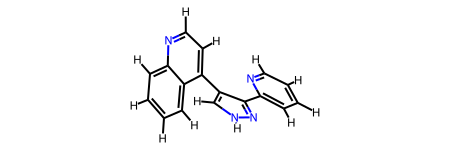

In [28]:
test_ref_mol

In [170]:
test_feats = [ChemicalFeatures.FreeChemicalFeature('Acceptor', Geometry.Point3D(3.877,7.014,1.448)),
             ChemicalFeatures.FreeChemicalFeature('Acceptor', Geometry.Point3D(7.22,11.077,5.625)),
             ChemicalFeatures.FreeChemicalFeature('Donor', Geometry.Point3D(4.778,8.4332,7.805)),
             ChemicalFeatures.FreeChemicalFeature('Aromatic',Geometry.Point3D(1.564,7.064,3.135))]
denovo_ph4 = Pharmacophore.Pharmacophore(test_feats)
denovo_ph4 = fuzzify_ph4(denovo_ph4)
test_mol2 = molecule_from_smiles_3D('c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1',embed=False)
align_fail, best_dev, best_mol = align_mol_to_ph4(test_mol2,denovo_ph4,
                                                  embed_count=50,optimize_energies=True,verbose=True)
score = score_ph4_alignment(best_mol,denovo_ph4,method='tversky')
print(score)

Molecule features can match pharmacophore; proceeding to embed
50 embeddings created successfully; proceeding to align
Alignment complete
Minimum SSD: 0.873479629214863
Done
0.7860918352955591


In [131]:
query_supp = "/gpfs/workspace/users/draytj01/3D-Pharm-Dversity-Library-47490.sdf"
# the ChemDiv 3D Pharmacophore-based Diversity Library
query_mols = mols_from_sdf(query_supp)
len(query_mols)

[16:12:39] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 4 ignored
[16:12:41] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 8 ignored
[16:12:50] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 9 ignored
[16:12:52] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 8 ignored
[16:12:52] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 3 ignored


47489

In [205]:
target_mol = query_mols[20000]
test_db = query_mols[19990:20010]
target_ph4,_ = ph4_from_molecule(target_mol,minimal=True)
types = [feat.GetFamily() for feat in target_ph4.getFeatures()]
types

['Acceptor',
 'Acceptor',
 'Acceptor',
 'Aromatic',
 'Aromatic',
 'Hydrophobe',
 'Hydrophobe',
 'Hydrophobe',
 'Hydrophobe',
 'Hydrophobe']

In [206]:
RDLogger.DisableLog('rdApp.*')
scores = []
for mol in test_db:
    align_failed, min_dev, conf = align_mol_to_ph4(mol,target_ph4,optimize_energies=False)
    if conf is not None:
        score = score_ph4_alignment(conf, target_ph4,method='tanimoto')
        scores.append(score)
    else:
        scores.append(0)
RDLogger.EnableLog('rdApp.*')

In [178]:
any(scores)>0
max_index = np.argmax(scores)
max_index

np.int64(10)

In [207]:
scores

[np.float64(0.23331134471080872),
 np.float64(0.01748958227712912),
 np.float64(0.08993792936889008),
 np.float64(0.024227315320101323),
 np.float64(0.054049124275048196),
 0,
 0,
 0,
 0,
 0,
 np.float64(0.933646100513412),
 0,
 np.float64(0.14219218990419044),
 0,
 0,
 0,
 0,
 np.float64(0.08571267725256893),
 np.float64(0.10432737264893228),
 np.float64(0.16323731583738058)]

In [11]:
smis = ['CC(OC(=O)c1c[nH]c2ccccc12)C1CCCCN1C',
        'CN1CCOc2c(C(=O)NC3CC4CCC(C3)N4C)cc(Cl)cc21',
        'CN1CC2CCC1CC2n1nnc2ccc(Cl)cc2c1=O']
mols = [molecule_from_smiles_3D(x,embed=True) for x in smis]

In [19]:
ph4s = [ph4_from_molecule(m)[0] for m in mols]
ref_feats = ph4s[0].getFeatures()
ref_pos = [list(x.GetPos()) for x in ref_feats]
probe_feats = ph4s[1].getFeatures()
probe_pos = [list(x.GetPos()) for x in probe_feats]

1